In [1]:
from PyStrategy import *

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [5]:
ttf_quotes = pd.read_csv('~/data/MM/ttf_m1_year_quotes.csv')
ttf_quotes['apply_from_utc'] = pd.to_datetime(ttf_quotes['apply_from_utc'])
ttf_quotes.sort_values('apply_from_utc', inplace = True)
ttf_quotes['timestamp'] = ttf_quotes['apply_from_utc'].astype(np.int64)
ttf_quotes['midprice'] = (ttf_quotes['ask_best_price'] + ttf_quotes['bid_best_price'])/2
ttf_quotes['spread'] = (ttf_quotes['ask_best_price'] - ttf_quotes['bid_best_price'])
ttf_quotes.fillna(0, inplace = True)
ttf_quotes.drop_duplicates(inplace = True)
ttf_dict_quotes = ttf_quotes.to_dict(orient = 'list')

In [6]:
the_quotes = pd.read_csv('~/data/MM/the_m1_year_quotes.csv')
the_quotes['apply_from_utc'] = pd.to_datetime(the_quotes['apply_from_utc'])
the_quotes.sort_values('apply_from_utc', inplace = True)
the_quotes['timestamp'] = the_quotes['apply_from_utc'].astype(np.int64)
the_quotes['midprice'] = (the_quotes['ask_best_price'] + the_quotes['bid_best_price'])/2
the_quotes['spread'] = (the_quotes['ask_best_price'] - the_quotes['bid_best_price'])
the_quotes.fillna(0, inplace = True)
the_quotes.drop_duplicates(inplace = True)
the_dict_quotes = the_quotes.to_dict(orient = 'list')

In [7]:
the_trades = pd.read_csv('~/data/MM/the_m1_year_trades.csv')
the_trades['trade_executed_at_utc'] = pd.to_datetime(the_trades['trade_executed_at_utc'])
the_trades.sort_values('trade_executed_at_utc', inplace = True)
the_trades['timestamp'] = the_trades['trade_executed_at_utc'].astype(np.int64)
the_dict_trades = the_trades.to_dict(orient = 'list')

In [8]:
def prepare_dicts(date_begin, date_end):
    ttf_dict_quotes = ttf_quotes[ttf_quotes['apply_from_utc'].between(date_begin, date_end)].to_dict(orient = 'list')
    the_dict_quotes = the_quotes[the_quotes['apply_from_utc'].between(date_begin, date_end)].to_dict(orient = 'list')
    the_dict_trades = the_trades[the_trades['trade_executed_at_utc'].between(date_begin, date_end)].to_dict(orient = 'list')
    return ttf_dict_quotes, the_dict_quotes, the_dict_trades

def prepare_data(date_begin, date_end):
    ttf_dict_quotes, the_dict_quotes, the_dict_trades = prepare_dicts(date_begin, date_end)
    the_dict_trades = the_trades[the_trades['trade_executed_at_utc'].between(date_begin, date_end)].to_dict(orient = 'list')
    #print(ttf_dict_quotes['apply_from_utc'][0])
    ttf_updates = []
    for i in range(len(ttf_dict_quotes['midprice'])):
        update = MDCustomMultipleUpdate()
        update.EventTimestamp = ttf_dict_quotes['timestamp'][i]
        update.Payload = {'instrument': 0, 'midprice':ttf_dict_quotes['midprice'][i], 'spread':ttf_dict_quotes['spread'][i]}
        ttf_updates.append(update)
        
    the_updates = []
    for i in range(len(the_dict_quotes['midprice'])):
        update = MDCustomMultipleUpdate()
        update.EventTimestamp = the_dict_quotes['timestamp'][i]
        update.Payload = {'instrument': 1, 'midprice':the_dict_quotes['midprice'][i], 'spread':the_dict_quotes['spread'][i]}
        the_updates.append(update)

    the_mdtrades = []
    for i in range(len(the_dict_trades['timestamp'])):
        trade_buy = MDTrade()
        trade_sell = MDTrade()
        trade_buy.Instrument = "THE"
        trade_sell.Instrument = "THE"
        trade_buy.EventTimestamp = the_dict_trades['timestamp'][i]
        trade_sell.EventTimestamp = the_dict_trades['timestamp'][i]
        trade_buy.Price = the_dict_trades['price'][i]
        trade_buy.Qty = the_dict_trades['quantity'][i]
        trade_sell.Price = the_dict_trades['price'][i]
        trade_sell.Qty = the_dict_trades['quantity'][i]
        trade_buy.AggressorSide = Side.Buy
        trade_sell.AggressorSide = Side.Sell
        the_mdtrades.append(trade_buy)
        the_mdtrades.append(trade_sell)

    return ttf_updates, the_updates, the_mdtrades

In [9]:
def get_strategy_summary(strategy):
    to_return = {}
    result = pd.DataFrame(strategy.GetFilledOrders())
    #buys = result[result['side'] == 'BUY']
    #sells = result[result['side'] == 'SELL']
    result['signed_qty'] = result['side'].replace({'SELL':-1,'BUY':1})*result['filled_qty']
    result['net_position'] = result.signed_qty.cumsum()
    result['cum_value'] = (-result.signed_qty * result.exec_price).cumsum()
    result['pnl'] = result['cum_value'] + result['net_position']*result['exec_price']
    return result

In [ ]:
data = {}
for date in pd.date_range('2024-01-01', '2024-01-31'): 
    ttf_updates, the_update, the_mdtrades = prepare_data(date.strftime('%Y-%m-%d'), (date + pd.Timedelta(days=1)).strftime('%Y-%m-%d'))
    print(date.strftime('%Y-%m-%d'), len(the_mdtrades))
    if len(ttf_updates) != 0:
        data[date] = [ttf_updates, the_update, the_mdtrades]

2024-01-01 0
2024-01-02 128
2024-01-03 124


In [11]:
#midprice-midprice spread
custom_updates = []
class MMStrategy(Strategy):
    def Init(self):
        self.offset = 0
        self.spread = 0.007
        self.sensitivity = 0.1
        self.bid_order = None
        self.ask_order = None
        self.last_ref_price = 0
        self.last_quoted_midprice = 0
        self.__position = 0
    
    def OnOrderFilled(self, order):
        #print(order.Type)
        #if order.OrderSide == Side.Buy:
        #    self.__position += order.FilledQty
        #else:
         #   self.__position -= order.FilledQty
        
    def OnTrade(self, trade):
        pass

    def RemoveQuotes(self):
        if (self.ask_order != None):
            self.CancelOrder(self.ask_order)
        if (self.bid_order != None):
            self.CancelOrder(self.bid_order)

    def ClosePosition(self):
        if (self.__position > 0):
            SendOrder("THE", 0, self.__position, Side.Sell, OrderType.Market)
        elif (self.__position < 0):
            SendOrder("THE", 0, self.__position, Side.Buy, OrderType.Market)
        
    def ReplaceQuotes(self):
        self.RemoveQuotes()
        if self.offset == 0:
            return
        self.bid_order = self.SendOrder("THE", self.last_ref_price + self.offset - self.last_ref_price*self.spread/2, 5, Side.Buy, OrderType.Limit)
        self.ask_order = self.SendOrder("THE", self.last_ref_price + self.offset + self.last_ref_price*self.spread/2, 5, Side.Sell, OrderType.Limit)

    def OnCustomMultipleUpdate(self, custom_update):
        if (custom_update.Payload['instrument'] == 0):
            if (custom_update.Payload['midprice'] < 0.01 or custom_update.Payload['spread'] > 0.3):
                self.RemoveQuotes()
                
            elif (abs(custom_update.Payload['midprice'] - self.last_ref_price) > self.sensitivity):
                self.last_ref_price = custom_update.Payload['midprice']
                self.ReplaceQuotes()
                
        else:
            if (custom_update.Payload['midprice'] > 0.01 and custom_update.Payload['spread'] < 0.3):
                self.offset = custom_update.Payload['midprice'] - self.last_ref_price
                self.last_quoted_midprice = custom_update.Payload['midprice']
            
def run_strategy(ttf_updates, the_updates, the_mdtrades):
    strategy = MMStrategy(0,0)
    strategy.Init()
    strategy.AddMDCustomMultipleUpdates({'ttf':ttf_updates, 'the': the_updates})
    strategy.AddMDTrades({'the':the_mdtrades})
    strategy.Run()
    return strategy

In [12]:
results = {}
for key in list(data.keys())[1:2]:
    results[key.strftime('%Y-%m-%d')] = run_strategy(data[key][0], data[key][1], data[key][2])
    print(key.strftime('%Y-%m-%d'))

OrderType.Limit
OrderType.Limit
OrderType.Limit
OrderType.Limit
OrderType.Limit
OrderType.Limit
OrderType.Limit
OrderType.Limit
OrderType.Limit
2024-01-03


In [25]:
summary = get_strategy_summary(results[begin])
summary

,instrument,nominal_price,exec_price,qty,state,filled_qty,create_timestamp,last_report_timestamp,side,type,text,signed_qty,net_position,cum_value,pnl
0,THE,32.144347,32.144347,5.0,OrderState.Filled,5.0,1704273091787000000,1704273091856000000,BUY,Limit,,5.0,5.0,-160.721737,0.000000
1,THE,32.401130,32.401130,5.0,OrderState.Filled,5.0,1704279200464000000,1704279222144000000,BUY,Limit,,5.0,10.0,-322.727387,1.283913
2,THE,33.071338,33.071338,5.0,OrderState.Filled,5.0,1704280999925000000,1704281155386000000,BUY,Limit,,5.0,15.0,-488.084075,7.985988
3,THE,32.622035,32.622035,5.0,OrderState.Filled,5.0,1704284915695000000,1704285240518000000,SELL,Limit,,-5.0,10.0,-324.973900,1.246450
4,THE,32.577921,32.577921,5.0,OrderState.Filled,5.0,1704291905120000000,1704292202911000000,BUY,Limit,,5.0,15.0,-487.863506,0.805313
5,THE,32.614675,32.614675,5.0,OrderState.Filled,5.0,1704292444063000000,1704292489792000000,SELL,Limit,,-5.0,10.0,-324.790131,1.356619
6,THE,32.814616,32.814616,5.0,OrderState.Filled,5.0,1704292608892000000,1704292871970000000,BUY,Limit,,5.0,15.0,-488.863213,3.356031
7,THE,32.830375,32.830375,5.0,OrderState.Filled,5.0,1704293566208000000,1704293664414000000,SELL,Limit,,-5.0,10.0,-324.711338,3.592413
8,THE,33.716536,33.716536,5.0,OrderState.Filled,5.0,1704299062252000000,1704299312804000000,BUY,Limit,,5.0,15.0,-493.294019,12.454025


In [147]:
results[begin].orders[-1].Type

<OrderType.Market: 0>

In [23]:
begin = '2024-01-03'
end = '2024-01-04'
ttf_dict_quotes, the_dict_quotes, the_dict_trades = prepare_dicts(begin, end)

In [41]:
orders = results[begin].GetOrders()
buy_orders = []
sell_orders = []
for order in orders:
    if (order['side'] == "BUY"):
        buy_orders.append(pd.DataFrame({'timestamp': [pd.to_datetime(order['create_timestamp']),pd.to_datetime(order['last_report_timestamp'])],
                       'price':[order['nominal_price'], order['nominal_price']]}))
    if (order['side'] == "SELL"):
        sell_orders.append(pd.DataFrame({'timestamp': [order['create_timestamp'], order['last_report_timestamp']],
                       'price':[order['nominal_price'], order['nominal_price']]}))

In [43]:
filled_orders = results[begin].GetFilledOrders()
buy_trades = {'timestamp':[], 'price':[]}
sell_trades = {'timestamp': [], 'price': []}

for order in filled_orders:
    if (order['side'] == "BUY"):
        buy_trades['timestamp'].append(pd.to_datetime(order['last_report_timestamp'], unit = 'ns'))
        buy_trades['price'].append(order['exec_price'])
    else:
        sell_trades['timestamp'].append(pd.to_datetime(order['last_report_timestamp'], unit = 'ns'))
        sell_trades['price'].append(order['exec_price'])

In [45]:
temp_quotes = pd.DataFrame(ttf_dict_quotes)
temp_quotes = temp_quotes[(temp_quotes['spread'] < 0.3) & (temp_quotes['midprice'] > 0.01)] 
temp_quotes = temp_quotes[temp_quotes.index % 10 == 0]

temp_quotes_the = pd.DataFrame(the_dict_quotes)
temp_quotes_the = temp_quotes_the[(temp_quotes_the['spread'] < 0.3) & (temp_quotes_the['midprice'] > 0.01)] 
temp_quotes_the = temp_quotes_the[temp_quotes_the.index % 10 == 0]

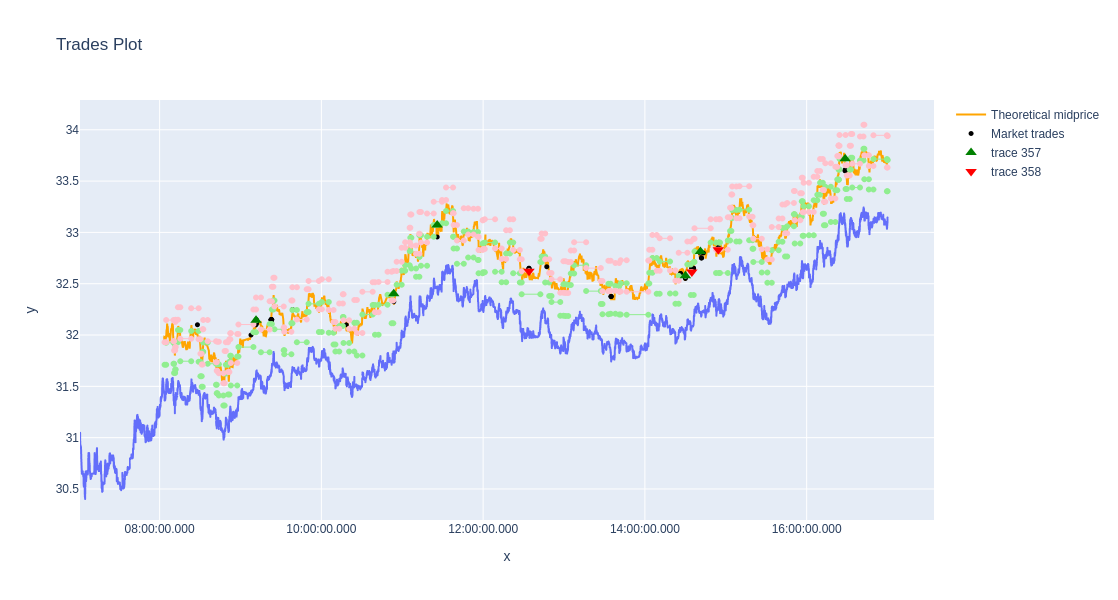

In [63]:
import warnings
warnings.filterwarnings('ignore')
line = px.line(
    x=pd.to_datetime(temp_quotes['timestamp'], unit = 'ns'),
    y=temp_quotes['midprice'],
    title="Trades Plot",
    width=1000,
    height=600
)

line.add_trace(go.Line(
    x=pd.to_datetime(temp_quotes_the['timestamp'], unit = 'ns'),
    y=temp_quotes_the['midprice'],
    marker=dict(color='orange', size=10),
    name="Theoretical midprice")
)

line.add_scatter(
    x=pd.to_datetime(the_dict_trades['timestamp'], unit = 'ns'),
    y=the_dict_trades['price'],
    mode="markers",
    marker=dict(color='black', size=5),
    name="Market trades"
)

for order in buy_orders:
    line.add_trace(go.Line(
    x=pd.to_datetime(order.timestamp, unit = 'ns'),
    y=order.price,
    name="Buy orders", 
    showlegend=False,
    line=dict(color='lightgreen', width=1)))

for order in sell_orders:
    line.add_trace(go.Line(
    x=pd.to_datetime(order.timestamp, unit = 'ns'),
    y=order.price,
    name="Sell orders", 
    showlegend=False,
    line=dict(color='pink', width=1)))

line.add_scatter(
    x = buy_trades['timestamp'],
    y = buy_trades['price'],
    mode="markers",
    marker=dict(color='green', size=10, symbol="triangle-up")
)

line.add_scatter(
    x = sell_trades['timestamp'],
    y = sell_trades['price'],
    mode="markers",
    marker=dict(color='red', size=10, symbol="triangle-down")
)
line.update_xaxes(tickformat="%H:%M:%S.%L")

line.show()

In [65]:
delete (custom_updates)

In [45]:
strategy = MMStrategy(0,0)

TypeError: MMStrategy() takes 1 positional argument but 2 were given

In [20]:
ttf_quotes['timestamp'] = ttf_quotes.appy_from_datetime.value

AttributeError: 'DataFrame' object has no attribute 'appy_from_datetime'